#CIFAR-10 Dataset

Link : https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


#About this Project



- In this project, we are required to gain some experience with transfer learning and some important concepts involved in transfer learning.

- We are given CIFAR-10 dataset which has a  total of 10 classes. One more class of "BoBcats" are added in this dataset and we have to build a model which classifies the newly added class.

- Furthermore, we have to analyze 14 models in order to have an in-depth understanding of transfer learning by freezing layers as well as transfer+learning (unfreezed) layers.

- We are given a base model with 7 main layers. We have to evaluate and construct new model by transferring (Freezing & learning) each layer one by one. For example, in the first model, we have to transfer the 1st layer and freeeze its weight and then in the second model, we have to again transfer the first layer and un freeze the weights of the layer. 

- By following the above step. we would acquire 14 models. For each model, we have to plot the accuracy/loss plot vs each epoch and also the confusion.

- At last, we have to analyze the overall performance of all the models in terms of accuracy/loss and freezing and unfreezing of layers.

#Major Steps in implementing the project

- Loading the CIFAR 10 dataset and adding the Bobcat images in it to create a new dataset.
- Train the given base model with the new dataset and save its weights.
- For the first model, freeze the first layer weights ad train the model. Similarly for second model we just have to unlock the weights and train it again.
- The above is repeated till all the 7 layers are trained in a similar manner.
- for every model trained, we have to save it so that we don't lose the model. 
- Plotting the results and analyzing it.
- Evaluate the new dataset by using the transfer learning method of different given models in the keras pretrained model API like RestNet50, VGG16, etc.

NOTE : Due to memory and time contraint, all the models have been trained for a maximum of 20 epochs and also to avoid overfiting as well as extra training, callbacks have also been implemented while compiling the model. Moreover, default learning rate have been chosen in order to have synchronization between all the models.

# Importing Libraries and Data

In [13]:
#importing libraries
from PIL import Image
from tensorflow.keras.datasets import cifar10
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.math import confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import glob,os
import keras

In [2]:
total_test_acc={}
total_test_loss={}

In [3]:
#downloading CIFAR-10 data    
(x_train, y_train), (x_test, y_test)=cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [4]:
#Printing the shapes of train and test data.
print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))

Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_test is (10000, 1)


# Loading of Bobcat Images into main dataset




In [5]:
# Loading the BOBCATS images from files and converting it into an array.

instances = []
for filepath in os.listdir("/content/drive/MyDrive/ENSF511_LabProject/converted-agumented"):  
    image=( Image.open('/content/drive/MyDrive/ENSF511_LabProject/converted-agumented/'+filepath))
    data=np.asarray(image)
    if data.shape!=(32,32,3): 
        print(filepath)
        continue
    instances.append(data)

bobcats=np.stack(instances, axis=0)
#shape of bobcat images array
print(bobcats.shape) 

(6000, 32, 32, 3)


In [6]:
#Creating a BOBTcat group numpy array and reshaping it.
bobcat_group=np.arange(6000).reshape(6000,1); 
bobcat_group.fill(10)
print(bobcat_group.shape)

(6000, 1)


In [7]:
#Concatenating BoBcat images to training and test sets of CIFAR-10
x_train=np.concatenate((x_train,bobcats[:5000,:,:,:]),axis=0)
x_test=np.concatenate((x_test,bobcats[5000:,:,:,:]),axis=0)
y_train=np.concatenate((y_train,bobcat_group[:5000]),axis=0)
y_test=np.concatenate((y_test,bobcat_group[5000:]),axis=0)

print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))


Shape of x_train is (55000, 32, 32, 3)
Shape of x_test is (11000, 32, 32, 3)
Shape of y_train is (55000, 1)
Shape of y_test is (11000, 1)


In [8]:
# Normalizing the train and test data.
x_train=x_train/255
x_test=x_test/255

#One hot encoding for the labels in train and test data.
y_train_cat=to_categorical(y_train,11)
y_test_cat=to_categorical(y_test,11)

print(y_train_cat.shape)
print(y_test_cat.shape)

(55000, 11)
(11000, 11)


In [9]:
#function to plot Confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  #print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


# MODEL TRAINING

## 1.1. Base model

In [10]:
#BASE MODEL

base_model = Sequential()
base_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
base_model.add(BatchNormalization())
base_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
base_model.add(BatchNormalization())
base_model.add(MaxPool2D((2, 2)))
base_model.add(Dropout(0.2))
base_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
base_model.add(BatchNormalization())
base_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
base_model.add(BatchNormalization())
base_model.add(MaxPool2D((2, 2)))
base_model.add(Dropout(0.3))
base_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
base_model.add(BatchNormalization())
base_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
base_model.add(BatchNormalization())
base_model.add(MaxPool2D((2, 2)))
base_model.add(Dropout(0.4))
base_model.add(Flatten())
base_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
base_model.add(BatchNormalization())
base_model.add(Dropout(0.5))
base_model.add(Dense(11, activation='softmax'))


In [ ]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

Training the data with base model.

In [ ]:
# compile model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=base_model.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 42s 23ms/step - loss: 1.6646 - accuracy: 0.4285 - val_loss: 1.4128 - val_accuracy: 0.5374
Epoch 2/20
1719/1719 [==============================] - 36s 21ms/step - loss: 1.1014 - accuracy: 0.6200 - val_loss: 0.9180 - val_accuracy: 0.6803
Epoch 3/20
1719/1719 [==============================] - 38s 22ms/step - loss: 0.8775 - accuracy: 0.7003 - val_loss: 0.7644 - val_accuracy: 0.7382
Epoch 4/20
1719/1719 [==============================] - 44s 26ms/step - loss: 0.7563 - accuracy: 0.7437 - val_loss: 0.6766 - val_accuracy: 0.7630
Epoch 5/20
1719/1719 [==============================] - 40s 23ms/step - loss: 0.6813 - accuracy: 0.7702 - val_loss: 0.5940 - val_accuracy: 0.8006
Epoch 6/20
1719/1719 [==============================] - 43s 25ms/step - loss: 0.6187 - accuracy: 0.7910 - val_loss: 0.5415 - val_accuracy: 0.8153
Epoch 7/20
1719/1719 [==============================] - 38s 22ms/step - loss: 0.5793 - accuracy: 0.8038 - val_loss: 0.5169 -

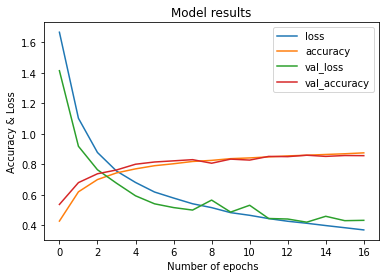

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 12s 9ms/step - loss: 0.4333 - accuracy: 0.8567
Test Accuracy: 0.8567273020744324


Normalized confusion matrix


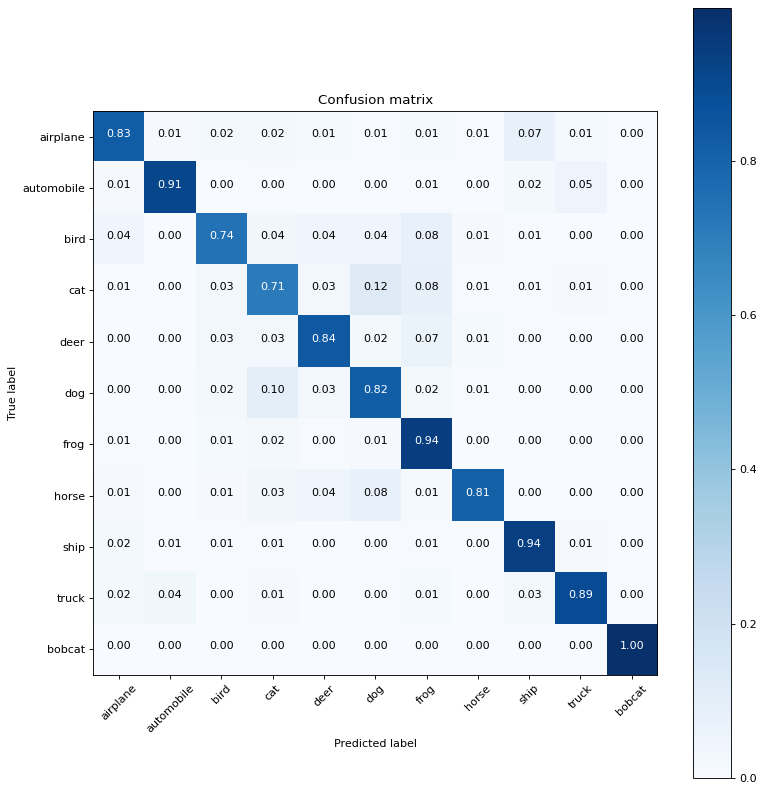

In [11]:
evaluation_base = base_model.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['base']= evaluation_base[1]
total_test_loss['base']= evaluation_base[0]

from matplotlib.pyplot import figure
p_test = base_model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(10, 10), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

- Saving the base model

In [ ]:
#base_model.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/base_model.h5')

In [10]:
base_model=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/base_model.h5')
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [11]:
len(base_model.layers)

23

In [ ]:
base_model.layers

In [ ]:
base_model.layers[-22]

1.1.1 Freezing 1st layer of the base_model (Trainable=False)

In [ ]:
#setting the trainable parameters to false so that we can use the pretrained parameters
model_1_base = keras.Model(inputs=base_model.input, outputs=base_model.layers[-22].output)
#freezing layers
for layer in model_1_base.layers:
  layer.trainable=False

#defining model with randon weights 
model_1_1= keras.Sequential()
model_1_1.add(model_1_base)
model_1_1.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_1_1.add(BatchNormalization())
model_1_1.add(MaxPool2D((2, 2)))
model_1_1.add(Dropout(0.2))
model_1_1.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_1_1.add(BatchNormalization())
model_1_1.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_1_1.add(BatchNormalization())
model_1_1.add(MaxPool2D((2, 2)))
model_1_1.add(Dropout(0.3))
model_1_1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_1_1.add(BatchNormalization())
model_1_1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_1_1.add(BatchNormalization())
model_1_1.add(MaxPool2D((2, 2)))
model_1_1.add(Dropout(0.4))
model_1_1.add(Flatten())
model_1_1.add(Dense(128, activation='relu', kernel_initializer='random_normal',bias_initializer='zeros'))
model_1_1.add(BatchNormalization())
model_1_1.add(Dropout(0.5))
model_1_1.add(Dense(11, activation='softmax'))

model_1_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 32, 32, 32)        1024      
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 64)       

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
model_1_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model_1_1.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 38s 22ms/step - loss: 1.5187 - accuracy: 0.4910 - val_loss: 0.9672 - val_accuracy: 0.6595
Epoch 2/20
1719/1719 [==============================] - 38s 22ms/step - loss: 0.9566 - accuracy: 0.6712 - val_loss: 0.7468 - val_accuracy: 0.7413
Epoch 3/20
1719/1719 [==============================] - 39s 23ms/step - loss: 0.8098 - accuracy: 0.7238 - val_loss: 0.7185 - val_accuracy: 0.7590
Epoch 4/20
1719/1719 [==============================] - 38s 22ms/step - loss: 0.7181 - accuracy: 0.7560 - val_loss: 0.5704 - val_accuracy: 0.8035
Epoch 5/20
1719/1719 [==============================] - 38s 22ms/step - loss: 0.6503 - accuracy: 0.7778 - val_loss: 0.5533 - val_accuracy: 0.8070
Epoch 6/20
1719/1719 [==============================] - 40s 23ms/step - loss: 0.5940 - accuracy: 0.7983 - val_loss: 0.5082 - val_accuracy: 0.8227
Epoch 7/20
1719/1719 [==============================] - 40s 24ms/step - loss: 0.5524 - accuracy: 0.8127 - val_loss: 0.4853 -

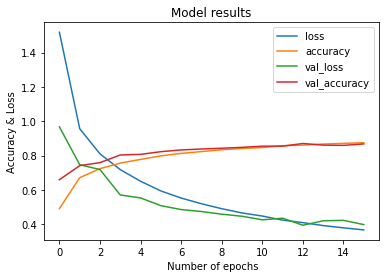

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 4s 11ms/step - loss: 0.3977 - accuracy: 0.8678
Test Accuracy: 0.8678181767463684


Normalized confusion matrix


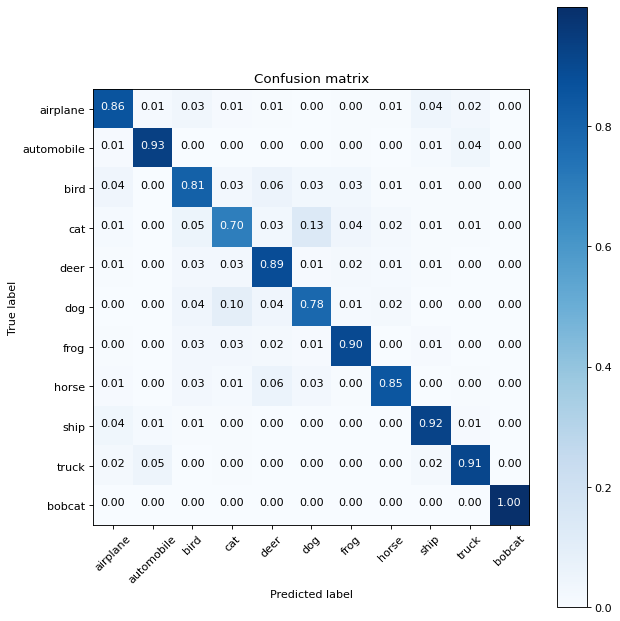

In [13]:
evaluation_base = model_1_1.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['1(f)']= evaluation_base[1]
total_test_loss['1(f)']= evaluation_base[0] 

from matplotlib.pyplot import figure
p_test = model_1_1.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

In [ ]:
model_1_1.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_1_1.h5')

In [12]:
model_1_1=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_1_1.h5')

1.1.2. Training till 1st layer of the base_model (Trainable=True)

In [ ]:
model_1_base = keras.Model(inputs=base_model.input, outputs=base_model.layers[-22].output)

#unfreezing layers
for layer in model_1_base.layers:
  layer.trainable=True

model_1_2= keras.Sequential()
model_1_2.add(model_1_base)
model_1_2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_1_2.add(BatchNormalization())
model_1_2.add(MaxPool2D((2, 2)))
model_1_2.add(Dropout(0.2))
model_1_2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_1_2.add(BatchNormalization())
model_1_2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_1_2.add(BatchNormalization())
model_1_2.add(MaxPool2D((2, 2)))
model_1_2.add(Dropout(0.3))
model_1_2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_1_2.add(BatchNormalization())
model_1_2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_1_2.add(BatchNormalization())
model_1_2.add(MaxPool2D((2, 2)))
model_1_2.add(Dropout(0.4))
model_1_2.add(Flatten())
model_1_2.add(Dense(128, activation='relu', kernel_initializer='random_normal',bias_initializer='zeros'))
model_1_2.add(BatchNormalization())
model_1_2.add(Dropout(0.5))
model_1_2.add(Dense(11, activation='softmax'))

model_1_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 32, 32, 32)        1024      
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 64)       

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
model_1_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model_1_2.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 37s 21ms/step - loss: 1.5128 - accuracy: 0.4848 - val_loss: 0.9494 - val_accuracy: 0.6572
Epoch 2/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.9663 - accuracy: 0.6676 - val_loss: 0.7922 - val_accuracy: 0.7356
Epoch 3/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.8240 - accuracy: 0.7180 - val_loss: 0.6507 - val_accuracy: 0.7707
Epoch 4/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.7235 - accuracy: 0.7542 - val_loss: 0.6778 - val_accuracy: 0.7663
Epoch 5/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.6556 - accuracy: 0.7774 - val_loss: 0.6910 - val_accuracy: 0.7646
Epoch 6/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.6005 - accuracy: 0.7976 - val_loss: 0.5149 - val_accuracy: 0.8225
Epoch 7/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.5612 - accuracy: 0.8092 - val_loss: 0.5542 -

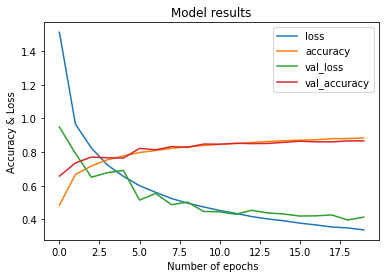

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 3s 7ms/step - loss: 0.4134 - accuracy: 0.8665
Test Accuracy: 0.8665454387664795
Normalized confusion matrix


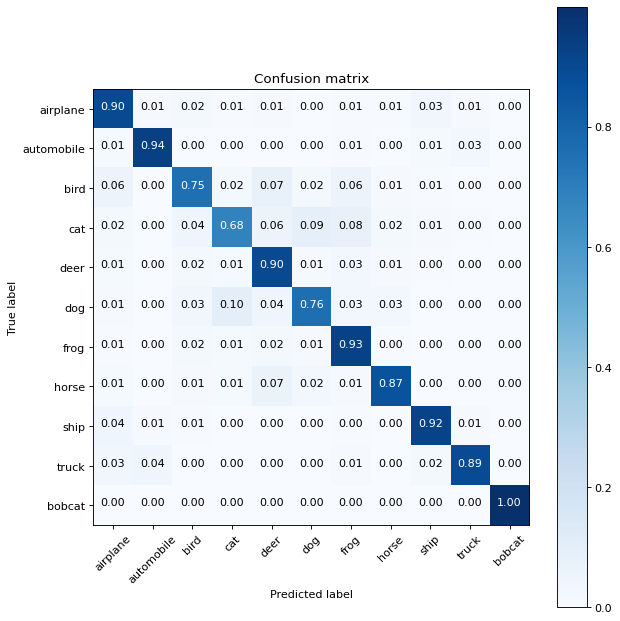

In [15]:
evaluation_base = model_1_2.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
total_test_acc['1(uf)']= evaluation_base[1]
total_test_loss['1(uf)']= evaluation_base[0] 

from matplotlib.pyplot import figure
p_test = model_1_2.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

In [ ]:
model_1_2.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_1_2.h5')

In [14]:
model_1_2=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_1_2.h5')

1.2.1 Freezing till 2nd layer of the base_model (Trainable=False)

In [ ]:
base_model.layers[-18]

In [ ]:
#setting the trainable parameters to false so that we can use the pretrained parameters
model_2_base = keras.Model(inputs=base_model.input, outputs=base_model.layers[-18].output)

#freezing layers
for layer in model_2_base.layers:
  layer.trainable=False

#defining model with randon weights 
model_2_1= keras.Sequential()
model_2_1.add(model_1_base)
model_2_1.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_2_1.add(BatchNormalization())
model_2_1.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_2_1.add(BatchNormalization())
model_2_1.add(MaxPool2D((2, 2)))
model_2_1.add(Dropout(0.3))
model_2_1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_2_1.add(BatchNormalization())
model_2_1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_2_1.add(BatchNormalization())
model_2_1.add(MaxPool2D((2, 2)))
model_2_1.add(Dropout(0.4))
model_2_1.add(Flatten())
model_2_1.add(Dense(128, activation='relu', kernel_initializer='random_normal',bias_initializer='zeros'))
model_2_1.add(BatchNormalization())
model_2_1.add(Dropout(0.5))
model_2_1.add(Dense(11, activation='softmax'))

model_2_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 32, 32, 32)        1024      
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_25 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_26 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 64)      

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
model_2_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model_2_1.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 44s 25ms/step - loss: 1.3824 - accuracy: 0.5383 - val_loss: 0.8428 - val_accuracy: 0.7073
Epoch 2/20
1719/1719 [==============================] - 39s 23ms/step - loss: 0.8684 - accuracy: 0.7035 - val_loss: 0.6900 - val_accuracy: 0.7626
Epoch 3/20
1719/1719 [==============================] - 39s 23ms/step - loss: 0.7351 - accuracy: 0.7468 - val_loss: 0.6084 - val_accuracy: 0.7847
Epoch 4/20
1719/1719 [==============================] - 39s 23ms/step - loss: 0.6402 - accuracy: 0.7797 - val_loss: 0.5430 - val_accuracy: 0.8088
Epoch 5/20
1719/1719 [==============================] - 39s 23ms/step - loss: 0.5722 - accuracy: 0.8034 - val_loss: 0.5191 - val_accuracy: 0.8231
Epoch 6/20
1719/1719 [==============================] - 39s 23ms/step - loss: 0.5190 - accuracy: 0.8213 - val_loss: 0.5025 - val_accuracy: 0.8302
Epoch 7/20
1719/1719 [==============================] - 39s 22ms/step - loss: 0.4752 - accuracy: 0.8380 - val_loss: 0.4696 -

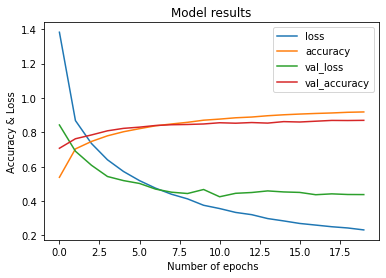

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 3s 8ms/step - loss: 0.4377 - accuracy: 0.8697
Test Accuracy: 0.8697272539138794


Normalized confusion matrix


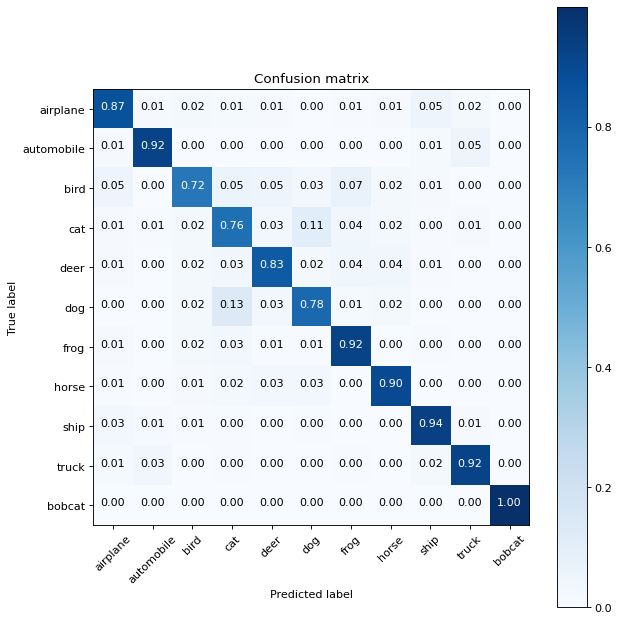

In [17]:
evaluation_base = model_2_1.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['2(f)']= evaluation_base[1]
total_test_loss['2(f)']= evaluation_base[0] 

from matplotlib.pyplot import figure
p_test = model_2_1.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

In [ ]:
model_2_1.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_2_1.h5')

In [16]:
model_2_1=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_2_1.h5')

1.2.2 Training till 2nd layer of the base_model (Trainable=False)

In [ ]:
#setting the trainable parameters to false so that we can use the pretrained parameters
model_2_base = keras.Model(inputs=base_model.input, outputs=base_model.layers[-18].output)

#freezing layers
for layer in model_2_base.layers:
  layer.trainable=True


#defining model with randon weights 
model_2_2= keras.Sequential()
model_2_2.add(model_1_base)
model_2_2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_2_2.add(BatchNormalization())
model_2_2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_2_2.add(BatchNormalization())
model_2_2.add(MaxPool2D((2, 2)))
model_2_2.add(Dropout(0.3))
model_2_2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_2_2.add(BatchNormalization())
model_2_2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_2_2.add(BatchNormalization())
model_2_2.add(MaxPool2D((2, 2)))
model_2_2.add(Dropout(0.4))
model_2_2.add(Flatten())
model_2_2.add(Dense(128, activation='relu', kernel_initializer='random_normal',bias_initializer='zeros'))
model_2_2.add(BatchNormalization())
model_2_2.add(Dropout(0.5))
model_2_2.add(Dense(11, activation='softmax'))

model_2_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 32, 32, 32)        1024      
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_30 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_31 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 64)      

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
model_2_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model_2_2.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 45s 25ms/step - loss: 1.3971 - accuracy: 0.5326 - val_loss: 0.9602 - val_accuracy: 0.6708
Epoch 2/20
1719/1719 [==============================] - 42s 24ms/step - loss: 0.9130 - accuracy: 0.6865 - val_loss: 0.7220 - val_accuracy: 0.7436
Epoch 3/20
1719/1719 [==============================] - 45s 26ms/step - loss: 0.7637 - accuracy: 0.7390 - val_loss: 0.6751 - val_accuracy: 0.7703
Epoch 4/20
1719/1719 [==============================] - 42s 25ms/step - loss: 0.6706 - accuracy: 0.7711 - val_loss: 0.6421 - val_accuracy: 0.7744
Epoch 5/20
1719/1719 [==============================] - 45s 26ms/step - loss: 0.6072 - accuracy: 0.7911 - val_loss: 0.5770 - val_accuracy: 0.7991
Epoch 6/20
1719/1719 [==============================] - 43s 25ms/step - loss: 0.5555 - accuracy: 0.8101 - val_loss: 0.5664 - val_accuracy: 0.8098
Epoch 7/20
1719/1719 [==============================] - 43s 25ms/step - loss: 0.5064 - accuracy: 0.8263 - val_loss: 0.5200 -

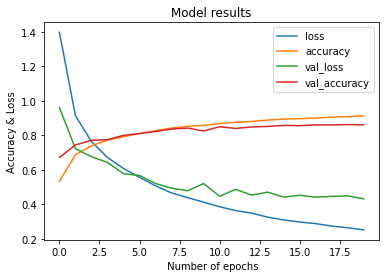

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 4s 10ms/step - loss: 0.4309 - accuracy: 0.8601
Test Accuracy: 0.8600909113883972


Normalized confusion matrix


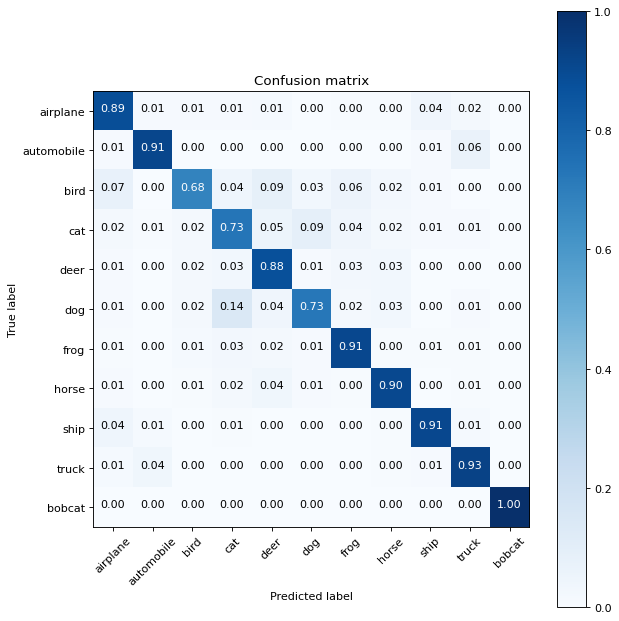

In [20]:

evaluation_base = model_2_2.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['2(uf)']= evaluation_base[1]
total_test_loss['2(uf)']= evaluation_base[0] 

from matplotlib.pyplot import figure
p_test = model_2_2.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

In [19]:
model_2_2.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_2_2.h5')

In [18]:
model_2_2=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_2_2.h5')

1.3.1 Freezing till 3rd layer of the base_model (Trainable=False)

In [ ]:
base_model.layers[-16]

In [12]:
#setting the trainable parameters to false so that we can use the pretrained parameters
model_3_base = keras.Model(inputs=base_model.input, outputs=base_model.layers[-16].output)
#freezing layers
for layer in model_3_base.layers:
  layer.trainable=False

#defining model with randon weights 
model_3_1= keras.Sequential()
model_3_1.add(model_3_base)
model_3_1.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_3_1.add(BatchNormalization())
model_3_1.add(MaxPool2D((2, 2)))
model_3_1.add(Dropout(0.3))
model_3_1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_3_1.add(BatchNormalization())
model_3_1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_3_1.add(BatchNormalization())
model_3_1.add(MaxPool2D((2, 2)))
model_3_1.add(Dropout(0.4))
model_3_1.add(Flatten())
model_3_1.add(Dense(128, activation='relu', kernel_initializer='random_normal',bias_initializer='zeros'))
model_3_1.add(BatchNormalization())
model_3_1.add(Dropout(0.5))
model_3_1.add(Dense(11, activation='softmax'))

model_3_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 16, 16, 64)        29152     
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         7

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
model_3_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model_3_1.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 46s 19ms/step - loss: 1.1137 - accuracy: 0.6282 - val_loss: 0.6698 - val_accuracy: 0.7670
Epoch 2/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.7447 - accuracy: 0.7469 - val_loss: 0.5713 - val_accuracy: 0.8016
Epoch 3/20
1719/1719 [==============================] - 32s 18ms/step - loss: 0.6477 - accuracy: 0.7792 - val_loss: 0.5115 - val_accuracy: 0.8264
Epoch 4/20
1719/1719 [==============================] - 31s 18ms/step - loss: 0.5896 - accuracy: 0.8003 - val_loss: 0.5261 - val_accuracy: 0.8215
Epoch 5/20
1719/1719 [==============================] - 31s 18ms/step - loss: 0.5402 - accuracy: 0.8172 - val_loss: 0.4598 - val_accuracy: 0.8445
Epoch 6/20
1719/1719 [==============================] - 31s 18ms/step - loss: 0.5076 - accuracy: 0.8264 - val_loss: 0.4515 - val_accuracy: 0.8477
Epoch 7/20
1719/1719 [==============================] - 31s 18ms/step - loss: 0.4772 - accuracy: 0.8401 - val_loss: 0.4425 -

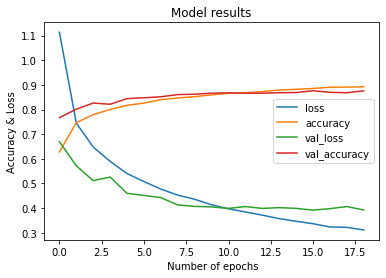

In [15]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 3s 7ms/step - loss: 0.3922 - accuracy: 0.8761
Test Accuracy: 0.8760908842086792


Normalized confusion matrix


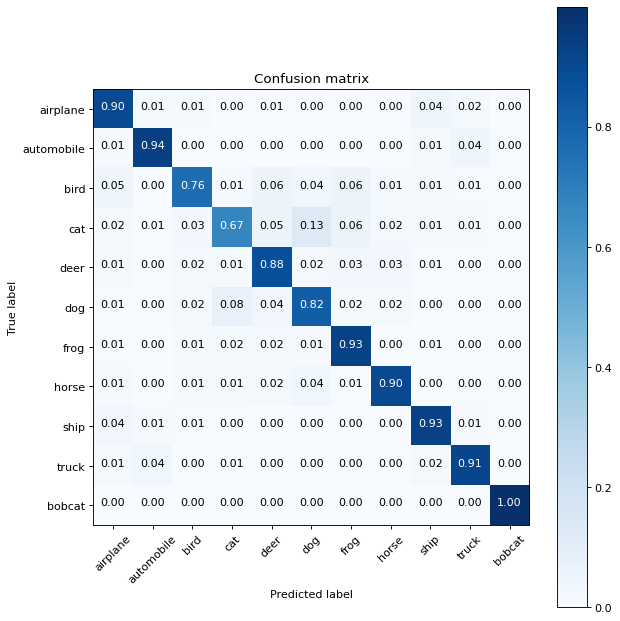

In [22]:

evaluation_base = model_3_1.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['3(f)']= evaluation_base[1]
total_test_loss['3(f)']= evaluation_base[0] 

from matplotlib.pyplot import figure
p_test = model_3_1.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

In [18]:
model_3_1.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_3_1.h5')

In [21]:
model_3_1=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_3_1.h5')

1.3.1 Training till 3rd layer of the base_model (Trainable=True)

In [ ]:
#setting the trainable parameters to false so that we can use the pretrained parameters
model_3_base = keras.Model(inputs=base_model.input, outputs=base_model.layers[-16].output)
#unfreezing layers
for layer in model_3_base.layers:
  layer.trainable=True

#defining model with randon weights 
model_3_2= keras.Sequential()
model_3_2.add(model_3_base)
model_3_2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_3_2.add(BatchNormalization())
model_3_2.add(MaxPool2D((2, 2)))
model_3_2.add(Dropout(0.3))
model_3_2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_3_2.add(BatchNormalization())
model_3_2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_3_2.add(BatchNormalization())
model_3_2.add(MaxPool2D((2, 2)))
model_3_2.add(Dropout(0.4))
model_3_2.add(Flatten())
model_3_2.add(Dense(128, activation='relu', kernel_initializer='random_normal',bias_initializer='zeros'))
model_3_2.add(BatchNormalization())
model_3_2.add(Dropout(0.5))
model_3_2.add(Dense(11, activation='softmax'))

model_3_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_6 (Functional)        (None, 16, 16, 64)        29152     
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization_39 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_33 (Conv2D)          (None, 8, 8, 128)        

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
model_3_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model_3_2.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 38s 21ms/step - loss: 1.1514 - accuracy: 0.6190 - val_loss: 0.7706 - val_accuracy: 0.7299
Epoch 2/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.7516 - accuracy: 0.7431 - val_loss: 0.5966 - val_accuracy: 0.7967
Epoch 3/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.6505 - accuracy: 0.7786 - val_loss: 0.5403 - val_accuracy: 0.8149
Epoch 4/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.5892 - accuracy: 0.8005 - val_loss: 0.4895 - val_accuracy: 0.8331
Epoch 5/20
1719/1719 [==============================] - 37s 21ms/step - loss: 0.5417 - accuracy: 0.8193 - val_loss: 0.4584 - val_accuracy: 0.8458
Epoch 6/20
1719/1719 [==============================] - 38s 22ms/step - loss: 0.5092 - accuracy: 0.8289 - val_loss: 0.4588 - val_accuracy: 0.8471
Epoch 7/20
1719/1719 [==============================] - 37s 21ms/step - loss: 0.4752 - accuracy: 0.8396 - val_loss: 0.4435 -

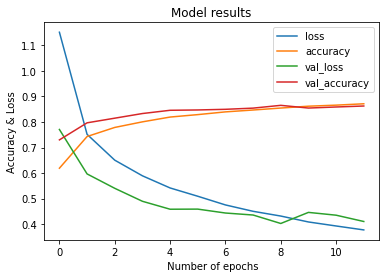

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 3s 7ms/step - loss: 0.4103 - accuracy: 0.8625
Test Accuracy: 0.8625454306602478
Normalized confusion matrix


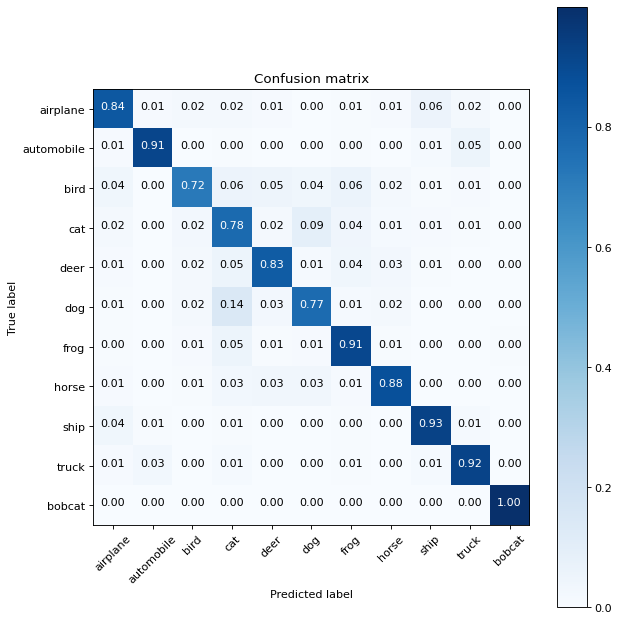

In [24]:

evaluation_base = model_3_2.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
total_test_acc['3(uf)']= evaluation_base[1]
total_test_loss['3(uf)']= evaluation_base[0] 

from matplotlib.pyplot import figure
p_test = model_3_2.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

In [ ]:
model_3_2.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_3_2.h5')

In [23]:
model_3_2=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_3_2.h5')

1.4.1 Training till 4th layer of the base_model (Trainable=True)

In [ ]:
base_model.layers[-12]

In [ ]:
#setting the trainable parameters to false so that we can use the pretrained parameters
model_4_base = keras.Model(inputs=base_model.input, outputs=base_model.layers[-12].output)
#freezing layers
for layer in model_4_base.layers:
  layer.trainable=False

#defining model with randon weights 
model_4_1= keras.Sequential()
model_4_1.add(model_4_base)
model_4_1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_4_1.add(BatchNormalization())
model_4_1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_4_1.add(BatchNormalization())
model_4_1.add(MaxPool2D((2, 2)))
model_4_1.add(Dropout(0.4))
model_4_1.add(Flatten())
model_4_1.add(Dense(128, activation='relu', kernel_initializer='random_normal',bias_initializer='zeros'))
model_4_1.add(BatchNormalization())
model_4_1.add(Dropout(0.5))
model_4_1.add(Dense(11, activation='softmax'))

model_4_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_7 (Functional)        (None, 8, 8, 64)          66336     
                                                                 
 conv2d_35 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 batch_normalization_43 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_36 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 batch_normalization_44 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 4, 4, 128)       

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
model_4_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model_4_1.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 22s 12ms/step - loss: 0.9126 - accuracy: 0.6948 - val_loss: 0.5483 - val_accuracy: 0.8158
Epoch 2/20
1719/1719 [==============================] - 21s 12ms/step - loss: 0.6277 - accuracy: 0.7870 - val_loss: 0.4968 - val_accuracy: 0.8327
Epoch 3/20
1719/1719 [==============================] - 23s 14ms/step - loss: 0.5532 - accuracy: 0.8122 - val_loss: 0.4609 - val_accuracy: 0.8443
Epoch 4/20
1719/1719 [==============================] - 25s 14ms/step - loss: 0.5107 - accuracy: 0.8280 - val_loss: 0.4464 - val_accuracy: 0.8471
Epoch 5/20
1719/1719 [==============================] - 25s 14ms/step - loss: 0.4804 - accuracy: 0.8387 - val_loss: 0.4214 - val_accuracy: 0.8589
Epoch 6/20
1719/1719 [==============================] - 25s 14ms/step - loss: 0.4522 - accuracy: 0.8469 - val_loss: 0.4165 - val_accuracy: 0.8601
Epoch 7/20
1719/1719 [==============================] - 25s 14ms/step - loss: 0.4294 - accuracy: 0.8553 - val_loss: 0.4222 -

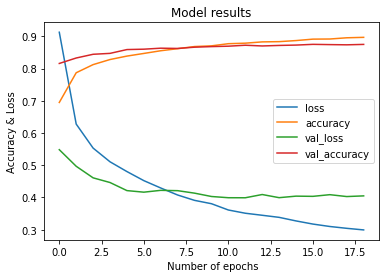

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 3s 8ms/step - loss: 0.4050 - accuracy: 0.8749
Test Accuracy: 0.8749091029167175


Normalized confusion matrix


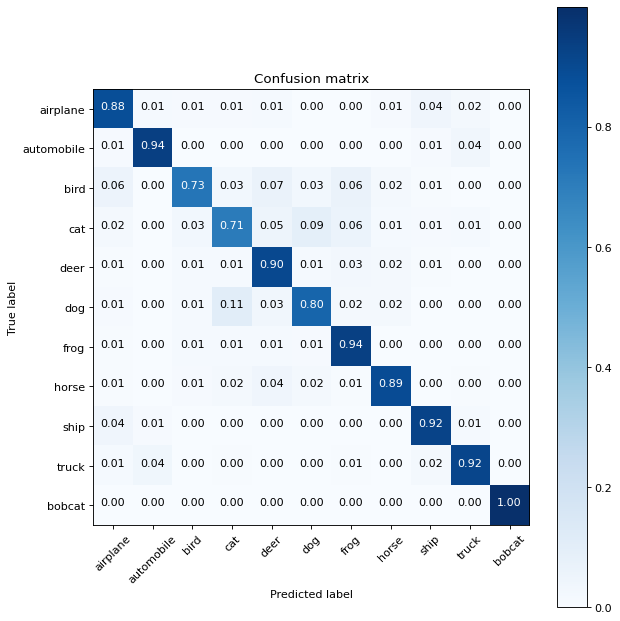

In [26]:

evaluation_base = model_4_1.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['4(f)']= evaluation_base[1]
total_test_loss['4(f)']= evaluation_base[0] 

from matplotlib.pyplot import figure
p_test = model_4_1.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

In [ ]:
model_4_1.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_4_1.h5')

In [25]:
model_4_1=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_4_1.h5')

1.4.2 Training till 4th layer of the base_model (Trainable=False)

In [ ]:
#setting the trainable parameters to false so that we can use the pretrained parameters
model_4_base = keras.Model(inputs=base_model.input, outputs=base_model.layers[-12].output)

#freezing layers
for layer in model_4_base.layers:
  layer.trainable=True

#defining model with randon weights 
model_4_2= keras.Sequential()
model_4_2.add(model_4_base)
model_4_2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_4_2.add(BatchNormalization())
model_4_2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_4_2.add(BatchNormalization())
model_4_2.add(MaxPool2D((2, 2)))
model_4_2.add(Dropout(0.4))
model_4_2.add(Flatten())
model_4_2.add(Dense(128, activation='relu', kernel_initializer='random_normal',bias_initializer='zeros'))
model_4_2.add(BatchNormalization())
model_4_2.add(Dropout(0.5))
model_4_2.add(Dense(11, activation='softmax'))

model_4_2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_8 (Functional)        (None, 8, 8, 64)          66336     
                                                                 
 conv2d_37 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 batch_normalization_46 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_38 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 batch_normalization_47 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 4, 4, 128)       

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
model_4_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model_4_2.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 36s 20ms/step - loss: 0.9065 - accuracy: 0.6993 - val_loss: 0.5643 - val_accuracy: 0.8082
Epoch 2/20
1719/1719 [==============================] - 34s 20ms/step - loss: 0.6121 - accuracy: 0.7921 - val_loss: 0.5153 - val_accuracy: 0.8243
Epoch 3/20
1719/1719 [==============================] - 34s 20ms/step - loss: 0.5509 - accuracy: 0.8134 - val_loss: 0.4845 - val_accuracy: 0.8379
Epoch 4/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.5011 - accuracy: 0.8304 - val_loss: 0.4667 - val_accuracy: 0.8456
Epoch 5/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.4704 - accuracy: 0.8414 - val_loss: 0.4761 - val_accuracy: 0.8432
Epoch 6/20
1719/1719 [==============================] - 35s 21ms/step - loss: 0.4405 - accuracy: 0.8507 - val_loss: 0.4255 - val_accuracy: 0.8569
Epoch 7/20
1719/1719 [==============================] - 35s 21ms/step - loss: 0.4187 - accuracy: 0.8585 - val_loss: 0.4658 -

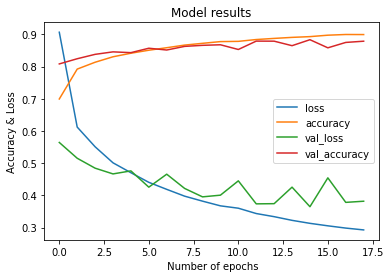

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 3s 7ms/step - loss: 0.3819 - accuracy: 0.8787
Test Accuracy: 0.8787272572517395


Normalized confusion matrix


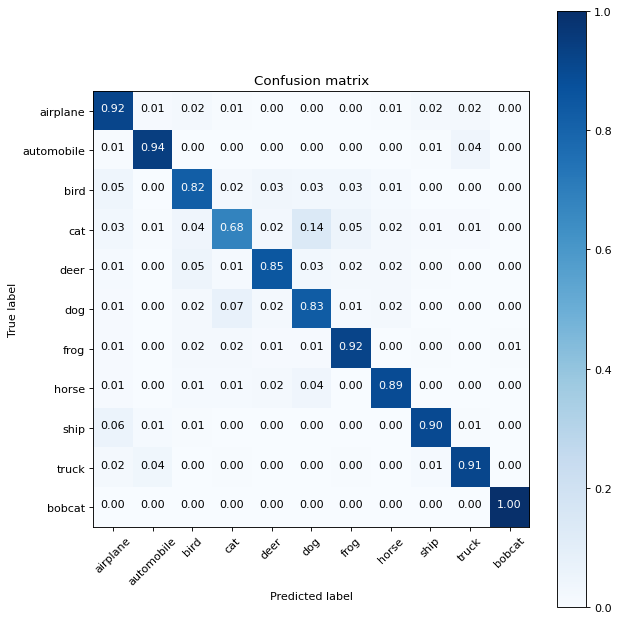

In [28]:

evaluation_base = model_4_2.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['4(uf)']= evaluation_base[1]
total_test_loss['4(uf)']= evaluation_base[0] 
from matplotlib.pyplot import figure
p_test = model_4_2.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

In [ ]:
model_4_2.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_4_2.h5')

In [27]:
model_4_2=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_4_2.h5')

1.5.1 Freezing till 5th layer of the base_model (Trainable=False)

In [ ]:
base_model.layers[-10]

In [ ]:
#setting the trainable parameters to false so that we can use the pretrained parameters
model_5_base = keras.Model(inputs=base_model.input, outputs=base_model.layers[-10].output)
#freezing layers
for layer in model_5_base.layers:
  layer.trainable=False

#defining model with randon weights 
model_5_1= keras.Sequential()
model_5_1.add(model_5_base)
model_5_1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_5_1.add(BatchNormalization())
model_5_1.add(MaxPool2D((2, 2)))
model_5_1.add(Dropout(0.4))
model_5_1.add(Flatten())
model_5_1.add(Dense(128, activation='relu', kernel_initializer='random_normal',bias_initializer='zeros'))
model_5_1.add(BatchNormalization())
model_5_1.add(Dropout(0.5))
model_5_1.add(Dense(11, activation='softmax'))

model_5_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_9 (Functional)        (None, 8, 8, 128)         140704    
                                                                 
 conv2d_39 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 batch_normalization_49 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 4, 4, 128)        0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 4, 4, 128)         0         
                                                                 
 flatten_10 (Flatten)        (None, 2048)            

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
model_5_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model_5_1.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 22s 12ms/step - loss: 0.6927 - accuracy: 0.7716 - val_loss: 0.4445 - val_accuracy: 0.8507
Epoch 2/20
1719/1719 [==============================] - 21s 12ms/step - loss: 0.4692 - accuracy: 0.8420 - val_loss: 0.4144 - val_accuracy: 0.8604
Epoch 3/20
1719/1719 [==============================] - 21s 12ms/step - loss: 0.4286 - accuracy: 0.8550 - val_loss: 0.3977 - val_accuracy: 0.8654
Epoch 4/20
1719/1719 [==============================] - 21s 12ms/step - loss: 0.4043 - accuracy: 0.8625 - val_loss: 0.3883 - val_accuracy: 0.8701
Epoch 5/20
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3822 - accuracy: 0.8713 - val_loss: 0.3829 - val_accuracy: 0.8711
Epoch 6/20
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3655 - accuracy: 0.8756 - val_loss: 0.3835 - val_accuracy: 0.8735
Epoch 7/20
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3532 - accuracy: 0.8801 - val_loss: 0.3863 -

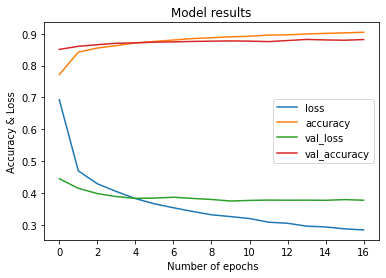

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 3s 7ms/step - loss: 0.3768 - accuracy: 0.8816
Test Accuracy: 0.881636381149292


Normalized confusion matrix


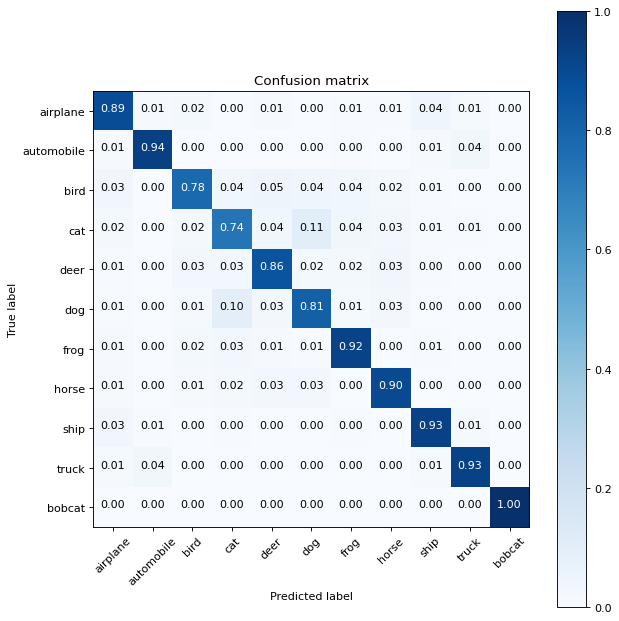

In [30]:

evaluation_base = model_5_1.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['5(f)']= evaluation_base[1]
total_test_loss['5(f)']= evaluation_base[0] 

from matplotlib.pyplot import figure
p_test = model_5_1.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

In [ ]:
model_5_1.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_5_1.h5')

In [29]:
model_5_1=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_5_1.h5')

1.5.2 Training till 5th layer of the base_model (Trainable=True)

In [ ]:
#setting the trainable parameters to false so that we can use the pretrained parameters
model_5_base = keras.Model(inputs=base_model.input, outputs=base_model.layers[-10].output)

#freezing layers
for layer in model_5_base.layers:
  layer.trainable=True

#defining model with randon weights 
model_5_2= keras.Sequential()
model_5_2.add(model_5_base)
model_5_2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
model_5_2.add(BatchNormalization())
model_5_2.add(MaxPool2D((2, 2)))
model_5_2.add(Dropout(0.4))
model_5_2.add(Flatten())
model_5_2.add(Dense(128, activation='relu', kernel_initializer='random_normal',bias_initializer='zeros'))
model_5_2.add(BatchNormalization())
model_5_2.add(Dropout(0.5))
model_5_2.add(Dense(11, activation='softmax'))

model_5_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_10 (Functional)       (None, 8, 8, 128)         140704    
                                                                 
 conv2d_40 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 batch_normalization_51 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 4, 4, 128)        0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 4, 4, 128)         0         
                                                                 
 flatten_11 (Flatten)        (None, 2048)            

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
model_5_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model_5_2.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 39s 22ms/step - loss: 0.7103 - accuracy: 0.7675 - val_loss: 0.4729 - val_accuracy: 0.8418
Epoch 2/20
1719/1719 [==============================] - 37s 21ms/step - loss: 0.4607 - accuracy: 0.8445 - val_loss: 0.4274 - val_accuracy: 0.8558
Epoch 3/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.4241 - accuracy: 0.8576 - val_loss: 0.3932 - val_accuracy: 0.8672
Epoch 4/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3908 - accuracy: 0.8684 - val_loss: 0.3916 - val_accuracy: 0.8712
Epoch 5/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3718 - accuracy: 0.8743 - val_loss: 0.3968 - val_accuracy: 0.8693
Epoch 6/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3577 - accuracy: 0.8794 - val_loss: 0.3743 - val_accuracy: 0.8745
Epoch 7/20
1719/1719 [==============================] - 35s 21ms/step - loss: 0.3347 - accuracy: 0.8871 - val_loss: 0.3740 -

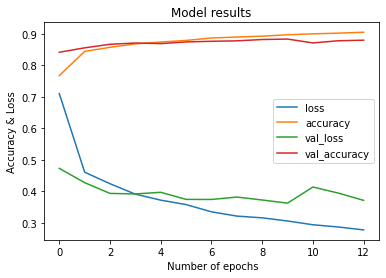

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 3s 7ms/step - loss: 0.3712 - accuracy: 0.8802
Test Accuracy: 0.8801817893981934


Normalized confusion matrix


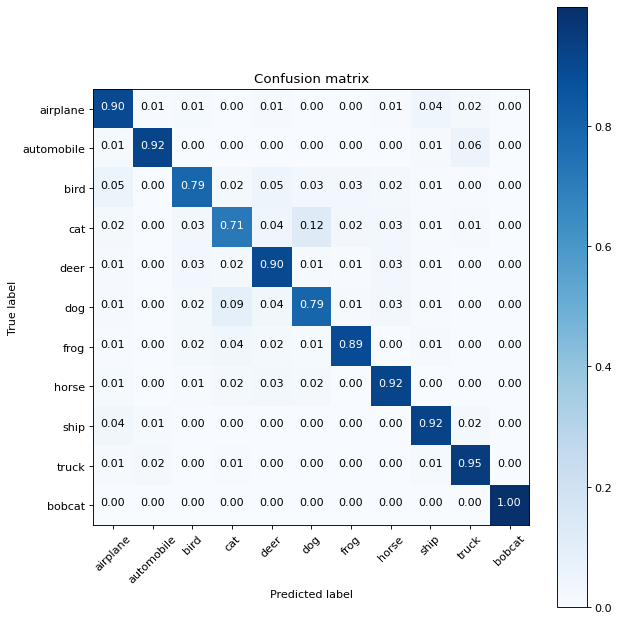

In [32]:

evaluation_base = model_5_2.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['5(uf)']= evaluation_base[1]
total_test_loss['5(uf)']= evaluation_base[0] 

from matplotlib.pyplot import figure
p_test = model_5_2.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

In [ ]:
model_5_2.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_5_2.h5')

In [31]:
model_5_2=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_5_2.h5')

1.6.1 Freezing till 6th layer of the base_model (Trainable=False)

In [ ]:
base_model.layers[-5]

In [19]:
#setting the trainable parameters to false so that we can use the pretrained parameters
model_6_base = keras.Model(inputs=base_model.input, outputs=base_model.layers[-5].output)
#freezing layers
for layer in model_6_base.layers:
  layer.trainable=False

#defining model with randon weights 
model_6_1= keras.Sequential()
model_6_1.add(model_6_base)
model_6_1.add(Dense(128, activation='relu', kernel_initializer='random_normal',bias_initializer='zeros'))
model_6_1.add(BatchNormalization())
model_6_1.add(Dropout(0.5))
model_6_1.add(Dense(11, activation='softmax'))

model_6_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2048)              288800    
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 11)                1419      
                                                                 
Total params: 553,003
Trainable params: 263,947
Non-trainable params: 289,056
__________________________________________

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
model_6_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model_6_1.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 22s 12ms/step - loss: 0.5480 - accuracy: 0.8175 - val_loss: 0.4062 - val_accuracy: 0.8665
Epoch 2/20
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3929 - accuracy: 0.8677 - val_loss: 0.3996 - val_accuracy: 0.8696
Epoch 3/20
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3691 - accuracy: 0.8728 - val_loss: 0.3978 - val_accuracy: 0.8688
Epoch 4/20
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3463 - accuracy: 0.8817 - val_loss: 0.3999 - val_accuracy: 0.8712
Epoch 5/20
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3405 - accuracy: 0.8829 - val_loss: 0.3933 - val_accuracy: 0.8708
Epoch 6/20
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3324 - accuracy: 0.8865 - val_loss: 0.3958 - val_accuracy: 0.8706
Epoch 7/20
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3331 - accuracy: 0.8872 - val_loss: 0.3981 -

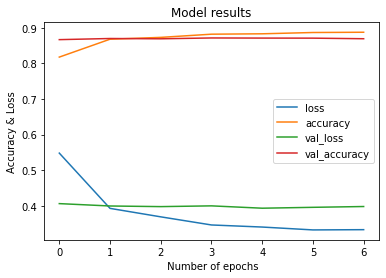

In [21]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 3s 7ms/step - loss: 0.3981 - accuracy: 0.8690
Test Accuracy: 0.8690000176429749


Normalized confusion matrix


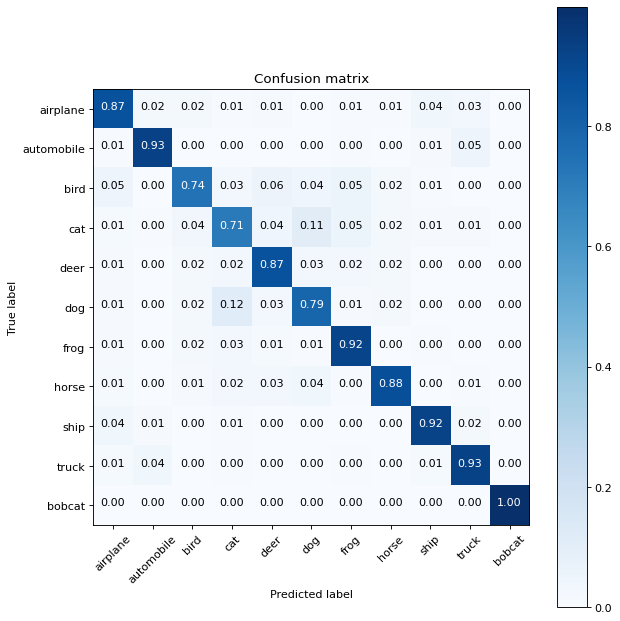

In [34]:

evaluation_base = model_6_1.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['6(f)']= evaluation_base[1]
total_test_loss['6(f)']= evaluation_base[0] 


from matplotlib.pyplot import figure
p_test = model_6_1.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

In [23]:
model_6_1.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_6_1.h5')

In [33]:
model_6_1=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_6_1.h5')

1.6.2 Training till 6th layer of the base_model (Trainable=true)

In [24]:
#setting the trainable parameters to false so that we can use the pretrained parameters
model_6_base = keras.Model(inputs=base_model.input, outputs=base_model.layers[-5].output)

#unfreezing layers
for layer in model_6_base.layers:
  layer.trainable=True

#defining model with randon weights 
model_6_2= keras.Sequential()
model_6_2.add(model_6_base)
model_6_2.add(Dense(128, activation='relu', kernel_initializer='random_normal',bias_initializer='zeros'))
model_6_2.add(BatchNormalization())
model_6_2.add(Dropout(0.5))
model_6_2.add(Dense(11, activation='softmax'))

model_6_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 2048)              288800    
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 11)                1419      
                                                                 
Total params: 553,003
Trainable params: 551,851
Non-trainable params: 1,152
____________________________________________

In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
model_6_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model_6_2.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 42s 23ms/step - loss: 0.5761 - accuracy: 0.8114 - val_loss: 0.4407 - val_accuracy: 0.8591
Epoch 2/20
1719/1719 [==============================] - 39s 23ms/step - loss: 0.4192 - accuracy: 0.8574 - val_loss: 0.4237 - val_accuracy: 0.8636
Epoch 3/20
1719/1719 [==============================] - 39s 23ms/step - loss: 0.3947 - accuracy: 0.8671 - val_loss: 0.4204 - val_accuracy: 0.8625
Epoch 4/20
1719/1719 [==============================] - 39s 23ms/step - loss: 0.3727 - accuracy: 0.8734 - val_loss: 0.4851 - val_accuracy: 0.8425
Epoch 5/20
1719/1719 [==============================] - 39s 23ms/step - loss: 0.3615 - accuracy: 0.8770 - val_loss: 0.4041 - val_accuracy: 0.8657
Epoch 6/20
1719/1719 [==============================] - 38s 22ms/step - loss: 0.3544 - accuracy: 0.8809 - val_loss: 0.3929 - val_accuracy: 0.8729
Epoch 7/20
1719/1719 [==============================] - 38s 22ms/step - loss: 0.3381 - accuracy: 0.8860 - val_loss: 0.4169 -

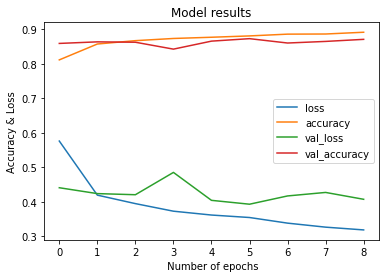

In [26]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 4s 11ms/step - loss: 0.4072 - accuracy: 0.8709
Test Accuracy: 0.8709090948104858


0.8709090948104858
0.40718767046928406
Normalized confusion matrix


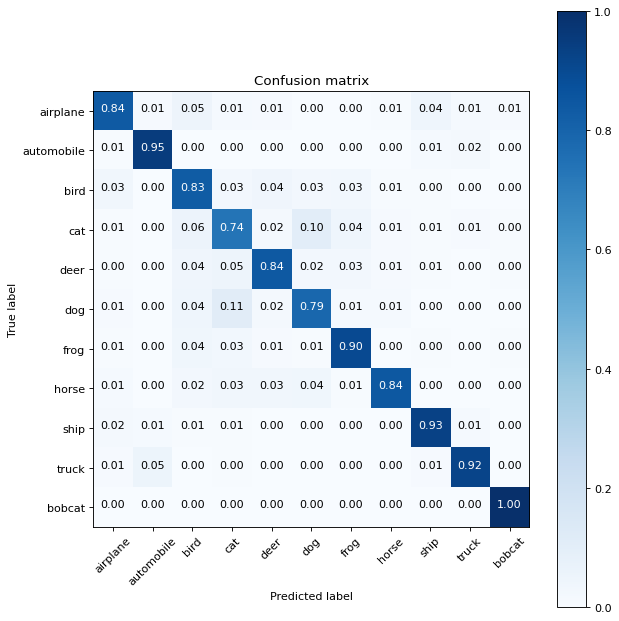

In [30]:

evaluation_base = model_6_2.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['6(uf)']= evaluation_base[1]
total_test_loss['6(uf)']= evaluation_base[0] 

print(total_test_acc['6(uf)'])
print(total_test_loss['6(uf)'] )

from matplotlib.pyplot import figure
p_test = model_6_2.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

In [ ]:
model_6_2.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_6_2.h5')

In [ ]:
model_6_2=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_6_2.h5')

1.7.1 Freezing till 7th layer of the base_model (Trainable=False)

In [ ]:
base_model.layers[-2]

In [ ]:
#setting the trainable parameters to false so that we can use the pretrained parameters
model_7_base = keras.Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
#freezing layers
for layer in model_7_base.layers:
  layer.trainable=False

#defining model with randon weights 
model_7_1= keras.Sequential()
model_7_1.add(model_7_base)
model_7_1.add(Dense(11, activation='softmax'))

model_7_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 128)               551584    
                                                                 
 dense_4 (Dense)             (None, 11)                1419      
                                                                 
Total params: 553,003
Trainable params: 1,419
Non-trainable params: 551,584
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
model_7_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model_7_1.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 23s 13ms/step - loss: 0.4003 - accuracy: 0.8719 - val_loss: 0.3873 - val_accuracy: 0.8782
Epoch 2/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2428 - accuracy: 0.9160 - val_loss: 0.3972 - val_accuracy: 0.8801
Epoch 3/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2341 - accuracy: 0.9199 - val_loss: 0.4011 - val_accuracy: 0.8803
Epoch 4/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2348 - accuracy: 0.9187 - val_loss: 0.4003 - val_accuracy: 0.8785
Epoch 5/20
1719/1719 [==============================] - 18s 11ms/step - loss: 0.2326 - accuracy: 0.9186 - val_loss: 0.4007 - val_accuracy: 0.8785
Epoch 6/20
1719/1719 [==============================] - 20s 11ms/step - loss: 0.2365 - accuracy: 0.9172 - val_loss: 0.4025 - val_accuracy: 0.8793


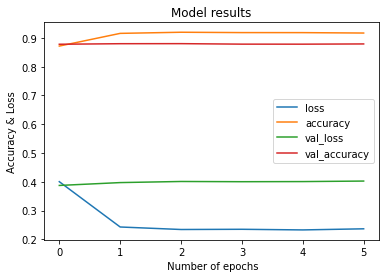

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 3s 7ms/step - loss: 0.4025 - accuracy: 0.8793
Test Accuracy: 0.8792726993560791


Normalized confusion matrix


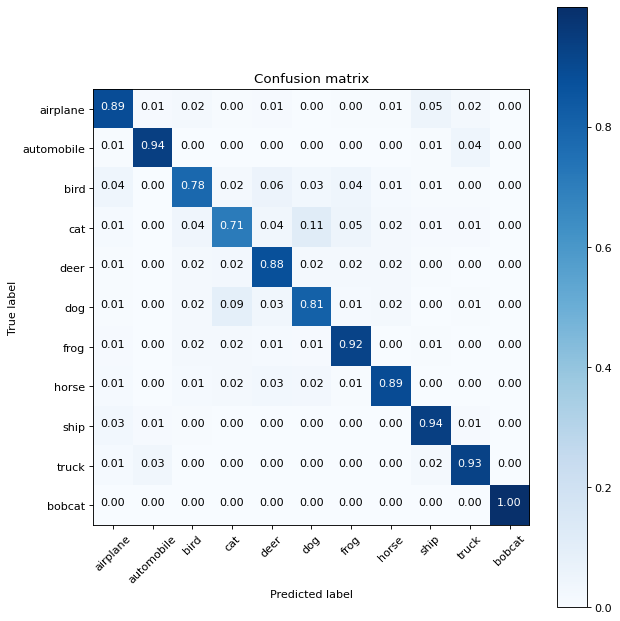

In [36]:

evaluation_base = model_7_1.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['7(f)']= evaluation_base[1]
total_test_loss['7(f)']= evaluation_base[0] 

from matplotlib.pyplot import figure
p_test = model_7_1.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

In [ ]:
model_7_1.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_7_1.h5')

In [35]:
model_7_1=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_7_1.h5')


1.7.2 Training till 3rd layer of the base_model (Trainable=True)

In [ ]:
#setting the trainable parameters to false so that we can use the pretrained parameters
model_7_base = keras.Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

#freezing layers
for layer in model_7_base.layers:
  layer.trainable=True

#defining model with randon weights 
model_7_2= keras.Sequential()
model_7_2.add(model_7_base)
model_7_2.add(Dense(11, activation='softmax'))
model_7_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 128)               551584    
                                                                 
 dense_5 (Dense)             (None, 11)                1419      
                                                                 
Total params: 553,003
Trainable params: 551,851
Non-trainable params: 1,152
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
model_7_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model_7_2.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 38s 21ms/step - loss: 0.4324 - accuracy: 0.8588 - val_loss: 0.4036 - val_accuracy: 0.8739
Epoch 2/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3015 - accuracy: 0.8981 - val_loss: 0.3879 - val_accuracy: 0.8766
Epoch 3/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.2814 - accuracy: 0.9041 - val_loss: 0.3700 - val_accuracy: 0.8829
Epoch 4/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.2727 - accuracy: 0.9078 - val_loss: 0.3964 - val_accuracy: 0.8756
Epoch 5/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.2662 - accuracy: 0.9089 - val_loss: 0.3848 - val_accuracy: 0.8782
Epoch 6/20
1719/1719 [==============================] - 35s 21ms/step - loss: 0.2629 - accuracy: 0.9097 - val_loss: 0.3902 - val_accuracy: 0.8793


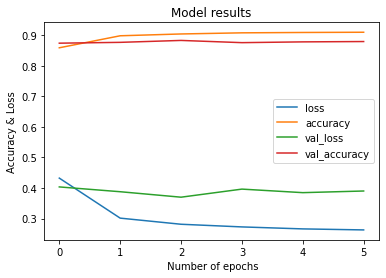

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 3s 7ms/step - loss: 0.3902 - accuracy: 0.8793
Test Accuracy: 0.8792726993560791


Normalized confusion matrix


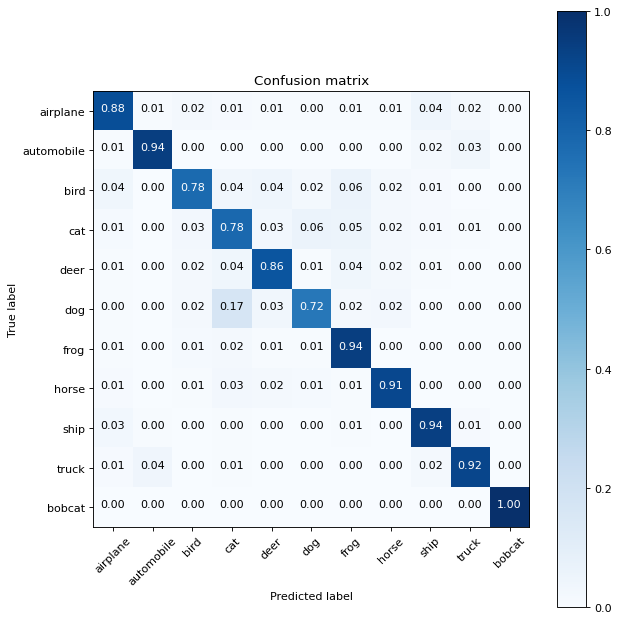

In [38]:

evaluation_base = model_7_2.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['7(uf)']= evaluation_base[1]
total_test_loss['7(uf)']= evaluation_base[0] 

from matplotlib.pyplot import figure
p_test = model_7_2.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

In [ ]:
model_7_2.save('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_7_2.h5')

In [37]:
model_7_2=keras.models.load_model('/content/drive/MyDrive/ENSF511_LabProject/Saved_Models/model_7_2.h5')


In [43]:
total_test_acc['6(uf)']= 0.8709090948104858
total_test_loss['6(uf)']=0.40718767046928406


In [83]:
#accuracy for unfreezed layers
total_test_acc_uf={}

for i in (list(total_test_acc.keys())):
  if("uf" in i):
    total_test_acc_uf[i]=total_test_acc[i]
  if("base" in i):
    total_test_acc_uf['base']=total_test_acc['base']
    
#accuracy for freezed layers
total_test_acc_f={}

for i in (list(total_test_acc.keys())):
  if("(f)" in i):
    total_test_acc_f[i]=total_test_acc[i]
  if("base" in i):
    total_test_acc_f['base']=total_test_acc['base']

#loss for unfreezed layers   
total_test_loss_uf={}

for i in (list(total_test_loss.keys())):
  if("uf" in i):
    total_test_loss_uf[i]=total_test_loss[i]
  if("base" in i):
    total_test_loss_uf['base']=total_test_loss['base']
    

#loss for freezed layers
total_test_loss_f={}

for i in (list(total_test_loss.keys())):
  if("(f)" in i):
    total_test_loss_f[i]=total_test_loss[i]
  if("base" in i):
    total_test_loss_f['base']=total_test_loss['base']


#2. Results

2.1 : Overall performance in terms of Accuracy for models with freezing of layers

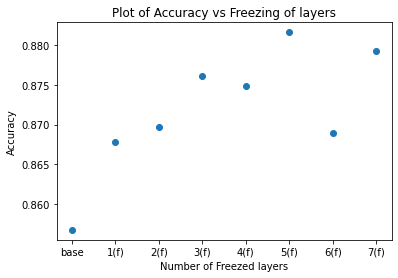

In [91]:

x = total_test_acc_f.keys()
y = total_test_acc_f.values()
plt.scatter(x,y)
plt.xlabel('Number of Freezed layers')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracy vs Freezing of layers')
plt.show()

- As we can see in the above scatter plot, when we freeze the weights of the different layers, one by onem accuracy initially increases and then decreases. But, as all the weights of the 7 layers are freezed, the accuracy once again increase. The base model have the lowest accuracy of all. 

2.2 : Overall performance in terms of Loss for models with freezing of layers

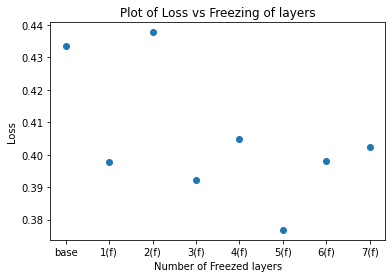

In [95]:
x = total_test_loss_f.keys()
y = total_test_loss_f.values()
plt.scatter(x,y)
plt.xlabel('Number of Freezed layers')
plt.ylabel('Loss')
plt.title('Plot of Loss vs Freezing of layers')
#plt.legend(total_test_acc.keys())
plt.show()

- The above scatter plot, resembles a similar plot to the accuracy one. As we can see, the loss is very high initially but then decreases and again increases when the weights of middle layers are freezed. When almost all the layers are freezed, the loss does decrease as compared to other models.

2.3 : Overall performance in terms of Accuracy for models with unfreezing (transfer+learning) of layers

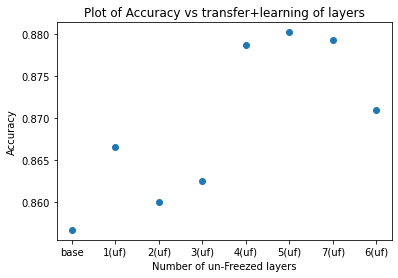

In [92]:
x = total_test_acc_uf.keys()
y = total_test_acc_uf.values()
plt.scatter(x,y)
plt.xlabel('Number of un-Freezed layers')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracy vs transfer+learning of layers')
#plt.legend(total_test_acc.keys())
plt.show()

- As we can see in the above scatter plot, when the weights of the layers are not freezed, it can be seen that, initially, the model has not a good accuracy as compared to the later models. When the weights are not freezed, the paramenters present in the layers get updated in accordance with the training.

2.4 : Overall performance in terms of Accuracy for models with unfreezing (transfer+learning) of layers

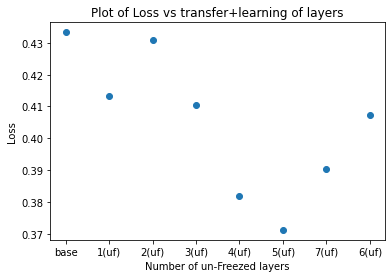

In [94]:
x = total_test_loss_uf.keys()
y = total_test_loss_uf.values()
plt.scatter(x,y)
plt.xlabel('Number of un-Freezed layers')
plt.ylabel('Loss')
plt.title('Plot of Loss vs transfer+learning of layers')
#plt.legend(total_test_acc.keys())
plt.show()

- The above scatter plot almost shows identical scatter plot related to the accuracy for the transfer+ learning layers in models. In the base model, the loss was pretty high as compared to the oter models. Initially, the loss is deascreased to some extent, but, again it rises in the 3rd model. The lowest loss is in 5th model and losses again in the models as number of transferred layers increased.

2.5 : Overall performance in terms of Accuracy for models with freezing and unfreezing (transfer+learning) of layers

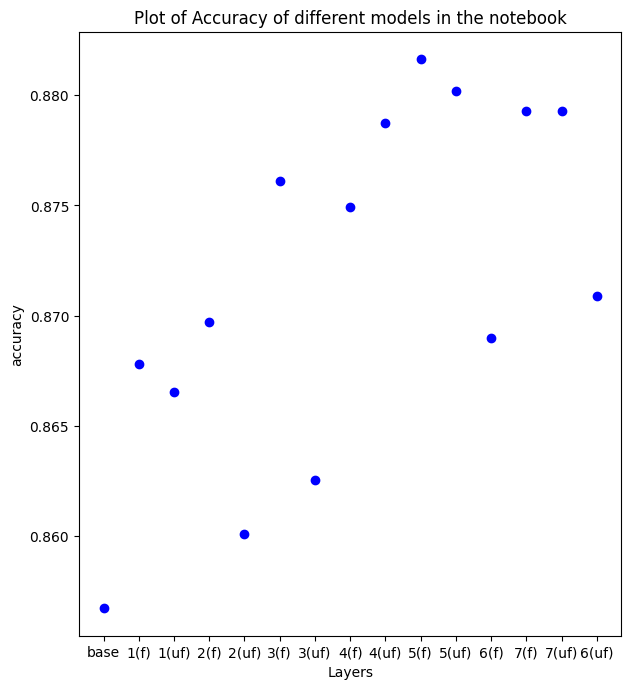

In [122]:
#x1 = total_test_loss_uf.keys()
x2 = total_test_acc.keys()
#y1 = total_test_loss_uf.values()
y2= total_test_acc.values()

#plt.scatter(x1,y1,color='blue')
plt.scatter(x2,y2,color= 'blue')
plt.rcParams.update({'figure.figsize':(6,8), 'figure.dpi':100})

plt.title('Plot of Accuracy of different models in the notebook')
plt.xlabel('Layers')
plt.ylabel('accuracy')
plt.show()

- In this scatter plot, we tried the capture the entire layers used in the project and plot it against the accuracy. By using this plot, we can examine that for every model how the freezing of the weights/layers takes place. AS we can see in the above plot, for initial models, the accuracy was not that much high. But, as soon as the number of layers has been increased, there has been increase in the accuracy. Also, as we can note here that, the accuracy is relatively less when we do transfer+learning as compared to freezing of layers. 

2.6 : Overall performance in terms of Loss for models with freezing and unfreezing (transfer+learning) of layers

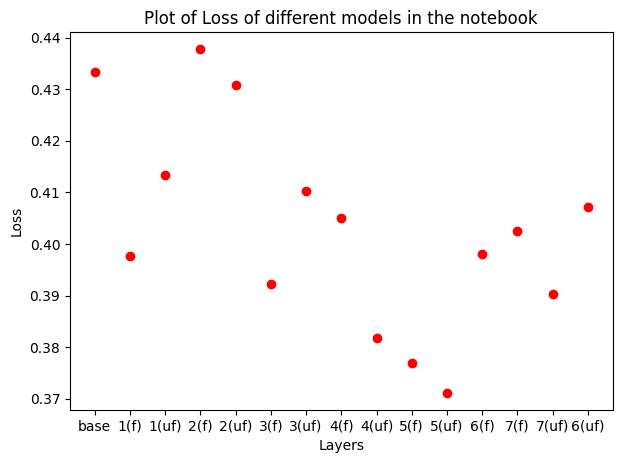

In [104]:
x1 = total_test_loss_uf.keys()
x2 = total_test_loss.keys()
y1 = total_test_loss_uf.values()
y2= total_test_loss.values()

#plt.scatter(x1,y1,color='blue')
plt.scatter(x2,y2,color= 'red')
plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})

plt.title('Plot of Loss of different models in the notebook')
plt.xlabel('Layers')
plt.ylabel('Loss')
plt.show()

- The above scatter plot depicts the loss in all the models presented in the notebook. As we can see that, initially the losses were high for the models with few transfered layers, but as the transfered layers increases to around 5, the loss decreased to the lowest, but again the loss increased. The losses for the unfreezing (tranfer +learning) is usually low as compared to the freezed layers. 

#3. Transfer learning with ResNet model

NOTE : Initially, we chose RestNet50 model for the purpose of pretrained model, but training on this dataset (even by un freezing some upper layers) yields a very poor result of around 35-40% accuracy and that's the reason, the model was discarded and we chose VGG-16. Below the results of training the new dataset with VGG16 pretrained model.

In [23]:
VGG16_model_1 = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),pooling='avg',weights='imagenet')

pretrained_model.trainaible=True

58900480/58889256 [==============================] - 1s 0us/step


In [24]:
len(pretrained_model.layers)

20

In [25]:
for layer in pretrained_model.layers:
        layer.trainable=False

In [26]:
VGG16_model_1.add(pretrained_model)
VGG16_model_1.add(Flatten())
VGG16_model_1.add(Dense(256, activation='relu'))
VGG16_model_1.add(Dense(11, activation='softmax'))

VGG16_model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 11)                2827      
                                                                 
Total params: 14,848,843
Trainable params: 134,155
Non-trainable params: 14,714,688
_________________________________________________________________


In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
VGG16_model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history=VGG16_model_1.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 51s 24ms/step - loss: 1.7139 - accuracy: 0.4274 - val_loss: 1.4811 - val_accuracy: 0.4985
Epoch 2/20
1719/1719 [==============================] - 40s 23ms/step - loss: 1.4199 - accuracy: 0.5194 - val_loss: 1.3784 - val_accuracy: 0.5331
Epoch 3/20
1719/1719 [==============================] - 40s 23ms/step - loss: 1.3407 - accuracy: 0.5451 - val_loss: 1.3288 - val_accuracy: 0.5454
Epoch 4/20
1719/1719 [==============================] - 40s 23ms/step - loss: 1.2965 - accuracy: 0.5594 - val_loss: 1.3018 - val_accuracy: 0.5560
Epoch 5/20
1719/1719 [==============================] - 40s 23ms/step - loss: 1.2654 - accuracy: 0.5688 - val_loss: 1.2825 - val_accuracy: 0.5630
Epoch 6/20
1719/1719 [==============================] - 44s 26ms/step - loss: 1.2420 - accuracy: 0.5762 - val_loss: 1.2673 - val_accuracy: 0.5666
Epoch 7/20
1719/1719 [==============================] - 40s 23ms/step - loss: 1.2223 - accuracy: 0.5834 - val_loss: 1.2560 -

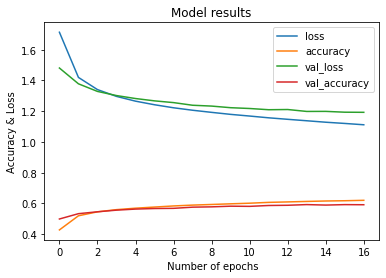

In [28]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 7s 21ms/step - loss: 1.1928 - accuracy: 0.5913
Test Accuracy: 0.5912727117538452


Normalized confusion matrix


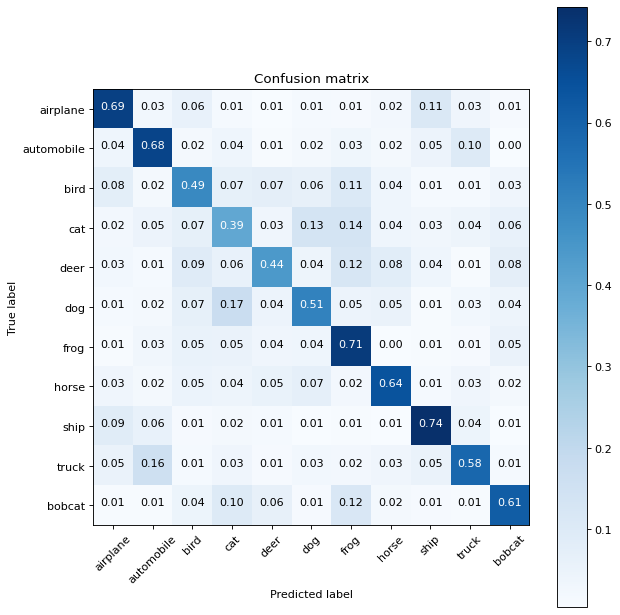

In [29]:

evaluation_base = VGG16_model_1.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['7(uf)']= evaluation_base[1]
total_test_loss['7(uf)']= evaluation_base[0] 

from matplotlib.pyplot import figure
p_test = VGG16_model_1.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

- The above model using pretrained VGG-16 model is performing poor as compared to the base model. In this model, all the layers are freezed and the number of trainable parameters are low while in the next model, let us unfreeze some layers and check if we can increase the performance.

In [38]:
VGG16_model_2 = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),pooling='avg',weights='imagenet')

pretrained_model.trainaible=True

for layer in pretrained_model.layers[:12]:
        layer.trainable=False

VGG16_model_2.add(pretrained_model)
VGG16_model_2.add(Flatten())
VGG16_model_2.add(Dense(128, activation='relu'))
VGG16_model_2.add(Dense(11, activation='softmax'))

VGG16_model_2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dense_11 (Dense)            (None, 11)                1419      
                                                                 
Total params: 14,781,771
Trainable params: 11,866,123
Non-trainable params: 2,915,648
_________________________________________________________________


In [39]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
VGG16_model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history=VGG16_model_2.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 78s 45ms/step - loss: 0.9880 - accuracy: 0.6608 - val_loss: 0.7600 - val_accuracy: 0.7378
Epoch 2/20
1719/1719 [==============================] - 78s 46ms/step - loss: 0.6717 - accuracy: 0.7703 - val_loss: 0.6946 - val_accuracy: 0.7660
Epoch 3/20
1719/1719 [==============================] - 77s 45ms/step - loss: 0.5117 - accuracy: 0.8232 - val_loss: 0.6697 - val_accuracy: 0.7805
Epoch 4/20
1719/1719 [==============================] - 81s 47ms/step - loss: 0.3767 - accuracy: 0.8692 - val_loss: 0.6551 - val_accuracy: 0.7921
Epoch 5/20
1719/1719 [==============================] - 77s 45ms/step - loss: 0.2687 - accuracy: 0.9085 - val_loss: 0.7654 - val_accuracy: 0.7772
Epoch 6/20
1719/1719 [==============================] - 81s 47ms/step - loss: 0.1876 - accuracy: 0.9356 - val_loss: 0.7802 - val_accuracy: 0.7873
Epoch 7/20
1719/1719 [==============================] - 81s 47ms/step - loss: 0.1396 - accuracy: 0.9516 - val_loss: 0.8854 -

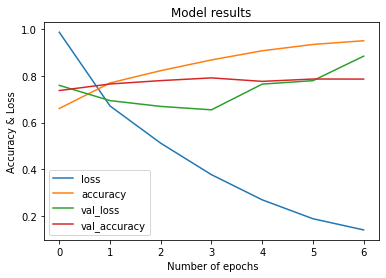

In [43]:
pd.DataFrame(history.history).plot()
plt.title('Model results')
plt.ylabel('Accuracy & Loss')
plt.xlabel(' Number of epochs')
plt.show()

344/344 [==============================] - 8s 22ms/step - loss: 0.8854 - accuracy: 0.7870
Test Accuracy: 0.7870000004768372


Normalized confusion matrix


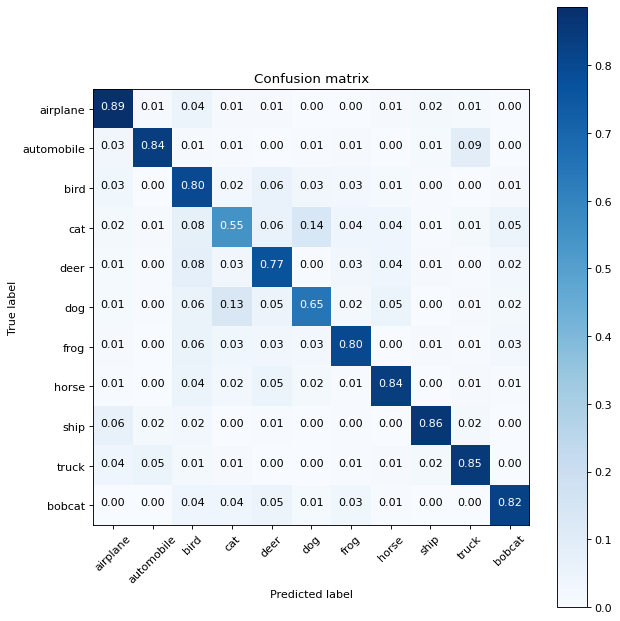

In [42]:

evaluation_base = VGG16_model_2.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation_base[1]))
print('\n')
total_test_acc['7(uf)']= evaluation_base[1]
total_test_loss['7(uf)']= evaluation_base[0] 

from matplotlib.pyplot import figure
p_test = VGG16_model_2.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
figure(figsize=(8, 8), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True)

- In the second model of VGG_16 we can see that the validation accuracy has but the train accuracy has increased and train loss has decreased exponentially which leads to the conclusion of overfitting. Let us unfreeze some more layers and see if accuracy can be increased can increased while decreaseing ovrfitting.

In [46]:
VGG16_model_3 = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),pooling='avg',weights='imagenet')

pretrained_model.trainaible=True

for layer in pretrained_model.layers[:8]:
        layer.trainable=False

VGG16_model_3.add(pretrained_model)
VGG16_model_3.add(Flatten())
VGG16_model_3.add(Dense(128, activation='relu'))
VGG16_model_3.add(Dense(11, activation='softmax'))

VGG16_model_3.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_8 (Flatten)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               65664     
                                                                 
 dense_17 (Dense)            (None, 11)                1419      
                                                                 
Total params: 14,781,771
Trainable params: 14,226,443
Non-trainable params: 555,328
_________________________________________________________________


In [47]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=3)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
VGG16_model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history=VGG16_model_3.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat),callbacks=[callback])

Epoch 1/20
1719/1719 [==============================] - 97s 55ms/step - loss: 0.9303 - accuracy: 0.6847 - val_loss: 0.6840 - val_accuracy: 0.7695
Epoch 2/20
1719/1719 [==============================] - 94s 55ms/step - loss: 0.5560 - accuracy: 0.8148 - val_loss: 0.6448 - val_accuracy: 0.7871
Epoch 3/20
1719/1719 [==============================] - 93s 54ms/step - loss: 0.3857 - accuracy: 0.8700 - val_loss: 0.5606 - val_accuracy: 0.8195
Epoch 4/20
1719/1719 [==============================] - 92s 54ms/step - loss: 0.2634 - accuracy: 0.9122 - val_loss: 0.5914 - val_accuracy: 0.8181
Epoch 5/20
1719/1719 [==============================] - 92s 54ms/step - loss: 0.1812 - accuracy: 0.9392 - val_loss: 0.6665 - val_accuracy: 0.8231
Epoch 6/20
1719/1719 [==============================] - 93s 54ms/step - loss: 0.1303 - accuracy: 0.9562 - val_loss: 0.7056 - val_accuracy: 0.8197
Epoch 7/20
1719/1719 [==============================] - 94s 55ms/step - loss: 0.1022 - accuracy: 0.9669 - val_loss: 0.6723 -

- In the last model of VGG_16 we can see very overfitted model as the train accuracy has increased very much as compared to test accuracy. We can conclude that our base model and other models which are based on base models perform better than the regular pretrained models like VGG_16 in the Keras API.